This project creates a model that classifies handwritten 3s and 7s from the MNIST sample dataset.

In [1]:
!pip install -Uqq fastai

In [2]:
from fastai.vision.all import *
matplotlib.rc('image', cmap='Greys')

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)

In [4]:
Path.BASE_PATH = path

.BASE_PATH is an attribute to path that tells where the starting point is.  
If you run 'path' it shows you where it is

In [5]:
path

Path('.')

In [6]:
path.ls()

(#3) [Path('train'),Path('labels.csv'),Path('valid')]

This lets us see what is in the directory.

In [7]:
type(path)

pathlib.PosixPath

pathlib is part of a Python standard library but doesn't have 'ls' command  so we have to add .ls. For instance path.ls().

In [8]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

This allows us to see what is in the train folder.

3s and 7s are labels/targets in the dataset.

In [9]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

This allows us to sort the data so that it is consistent/ get the same order of files.

In [10]:
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [11]:
sevens

(#6265) [Path('train/7/10002.png'),Path('train/7/1001.png'),Path('train/7/10014.png'),Path('train/7/10019.png'),Path('train/7/10039.png'),Path('train/7/10046.png'),Path('train/7/10050.png'),Path('train/7/10063.png'),Path('train/7/10077.png'),Path('train/7/10086.png')...]

In [12]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

This allows us to see one image from the 3s folder after sorting.

In [13]:
type(im3)

PIL.PngImagePlugin.PngImageFile

The im3 image is a png file.  
We need to represent this in number format as everything is represented as numbers in computers.  
To view the number that represent this image we convert it to a Numpy array or PyTorch tensor.

To convert it to a Numpy array:


In [14]:
array(im3)[4:10, 4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

This shows us an index of a number at the top left from 4 up to the number before 10. (It does not include 10).  
[4:10, 4:10] represents [rows, columns]

There are 8 bit integer, thus between 0 and 255.

To convert to a PyTorch Tensor:
    

In [15]:
tensor(im3)[4:10, 4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

PyTorch tensors and Numpy arrays behave the same but PyToch tensors can be computed on GPU and not onlu in CPUs like numpy arrays.

In [16]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15, 4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


im3_t = tensor(im3) -> grabs im3 and turns it to a tensor.  
df = pd.DataFrame(im3_t[4:15, 4:22]) -> grabs part of the image, that is [4:15, 4:22]  
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys') -> turns it to a panda's dataframe


Reason for turning it to a panda dataframe is because panda's dataframe has a convenient thing called background_gradient() that turns a background into a gradient.

In the output, 0s are the whites and 255 are the blacks. Then there are shades of grey that vary between 0 and 255.

## Creating a model that detects a 3

Idea is, if it doesn't recognise that a number is a 3, then it must be a 7.

### Pixel Similarity

- Find the average pixel value forevery pixe; of the threes and sevens.  
- The two group averages define the "ideal" 3 and 7.  
- Then to classify an image as a digit, we see which of these two ideal digits the image is similar to.

#### Create a baseline model

Baseline model -> a simple model which you are confident that it can perform reasonably well, should be simple to implement and easy to test.

First, we need to list all the images of sevens and threes as tensors.

In [17]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors), len(seven_tensors)

(6131, 6265)

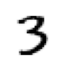

In [18]:
show_image(three_tensors[1]);

We can now display one of the 3s in the three_tensor list.  
Remember, this is a tensor and not a PIL image as we had seen before. Jupyter doesn't know how to display tensor so we use show_image().

We now need to get the average of all those 3s and 7s.  
First we need to change three_tensors and seven_tensors from lists, which can't easily do mathematical computations.

In [19]:
type(seven_tensors)

list

So we first stack all these 28×28 pixels images on top of each other to create like a 3D cube of images, quite like a tensor.

In [20]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

This turns the list to a tensor so the shape is now 6131 by 28 by 28.  
More like a cube of height 6131 that is 28×28.

Now if we are going to find the mean, we need to change them to floating point values because we don't want to kind of have integers rounding off.  
Also, its kind of a standard in computer vision that when you are working with floats, expect them to be between 0 and 1, so we divide by 255 because they are between 0 and 255.

The output is a Rank 3 tensor as it has three axes.

In [21]:
len(stacked_threes.shape)

3

We can also get it from 'ndim' that stands for number of dimensions.

In [23]:
stacked_threes.ndim

3

Numpy tends to call it axis, PyTorch tends to call it dimension.

Rank -> Number of axes or dimensions in a tensor.  
Shape -> Size of each axis of a tensor.

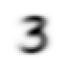

In [25]:
mean3 = stacked_threes.mean(0)
show_image(mean3);

This gives us the mean of just the 0 axis, that is the mean across the images.  
Takes the mean across the 6131 axis.

When we show the image, we get the 'ideal' 3.

Now we, we can do the same for 7:

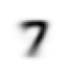

In [27]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

This shows us the 'ideal' 7.

Now, let's grab a 3:

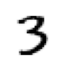

In [28]:
a_3 = stacked_threes[1]
show_image(a_3);

We can find if the a_3 is similar to the 'ideal' 3 or 7.  
The one that is more similar to, that's the answer.

We just can't add up the difference between the pixel of the image and the ideal digit because some differences will be negative and some will be positive and they'll cancel out. This will result in an image thats too dark in some places and too light in others.

To avoid this, we have to make them all positive values.  
This can be achieved by:  
1) Finding the absolute values (simply means removing the minus sign), the take the average. This is called the Mean Absolute Difference or L1 norm.  
2) Take the square of each difference and the take the mean then find the square root to undo the squaring. This is called Root Mean Squared Error or L2 norm.
    

In [30]:
dist_3_abs = (a_3-mean3).abs().mean()
dist_3_sqr = ((a_3-mean3)**2).mean().sqrt()
dist_3_abs, dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [31]:
dist_7_abs = (a_3-mean7).abs().mean()
dist_7_sqr = ((a_3-mean7)**2).mean().sqrt()
dist_7_abs, dist_7_sqr

(tensor(0.1586), tensor(0.3021))

We do for both 3 and 7.